In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle, shutil, random

from collections import Counter


In [27]:
BASE_PATH = Path('/project/volume/data/out')

MODEL_PATH = Path('/project/volume/models')

EMOREACT = Path('EmoReact')
FER = Path('FER-2013')
KDEF = Path('KDEF-AKDEF')
NIMH = Path('NIMH-CHEFS')

In [28]:
DATA = FER

In [29]:
CURRENT_PATH = BASE_PATH / DATA
LABELS = [f.name for f in CURRENT_PATH.iterdir() if f.is_dir()]

IMAGE_PATHS = list(CURRENT_PATH.rglob('*.jpg'))
IMAGE_PATHS_STR = [str(path) for path in IMAGE_PATHS]

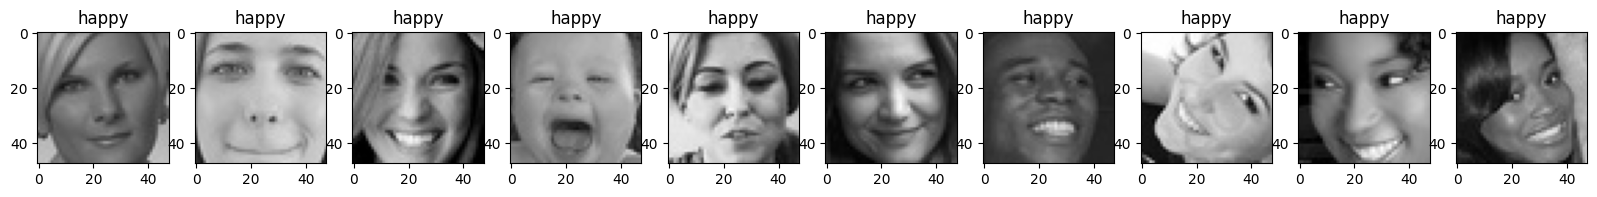

In [6]:
fig = plt.figure(figsize=(20,20))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    plt.imshow(np.array(cv2.imread(str(IMAGE_PATHS[i]))), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

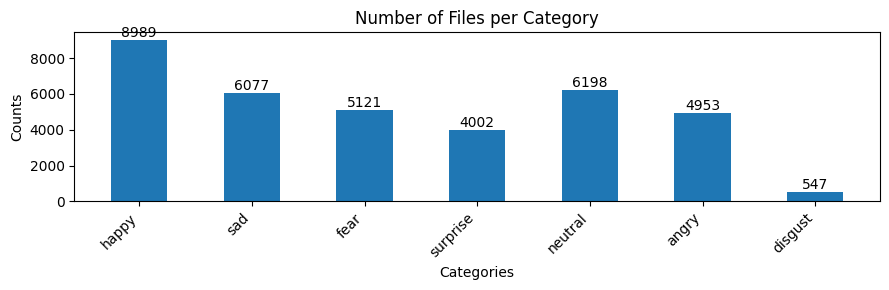

In [10]:
nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)
categories = list(nbr_per_cat.keys())
counts = list(nbr_per_cat.values())

plt.figure(figsize=(9, 3))
bars = plt.bar(categories, counts, width=0.5)

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Number of Files per Category')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
def read_mp_cv2_image(image_path):
    return Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

def to_grayscale(image_path):
    img = cv2.imread(image_path)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return imgray

def resize_image(image, size):
    return cv2.resize(image, (size,size))

def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

## Facial Landmarks

In [11]:
from mediapipe import Image
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import mediapipe as mp

In [13]:
model_path_mesh = '/project/volume/models/face_landmarker.task'

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

W0000 00:00:1717930880.003780     111 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [25]:
def extract_landmarks():
    lm_labels = []
    lm_data = []

    for file in tqdm(IMAGE_PATHS):
        img_cv2 = to_grayscale(str(file))
        img_cv2 = resize_image(img_cv2, 128)
        rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
        detection_result = detector_mesh.detect(rgb_frame)

        if detection_result.face_landmarks:
            lm_array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
            lm_labels.append(file.parent.name)
            lm_data.append(lm_array)

    lm_labels = np.array(lm_labels)
    lm_data = np.array(lm_data)

    return lm_data, lm_labels

In [26]:
lm_data, lm_labels = extract_landmarks()

x_train, x_test, y_train, y_test = train_test_split(lm_data, lm_labels, test_size=0.2, shuffle=True, stratify=hog_labels, random_state=42)
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_estimator_landmark = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)
model_name = 'lm_model.p'
model_path = str(MODEL_PATH / DATA / model_name)
pickle.dump(best_estimator_landmark, open(model_path, 'wb'))

print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator_landmark, x_train, y_train, x_test, y_test, train=False)

  2%|â–‰                                                        | 571/35887 [00:09<09:52, 59.61it/s]


KeyboardInterrupt: 